实验要求：实现对彩色图像的灰度处理，并使用高斯一阶导数滤波器计算图像梯度，进而执行非极大值抑制和阈值操作及连接，从而进行canny边缘检测。

In [19]:
import cv2
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
#这里引入cv2仅仅是用Mat存储图片

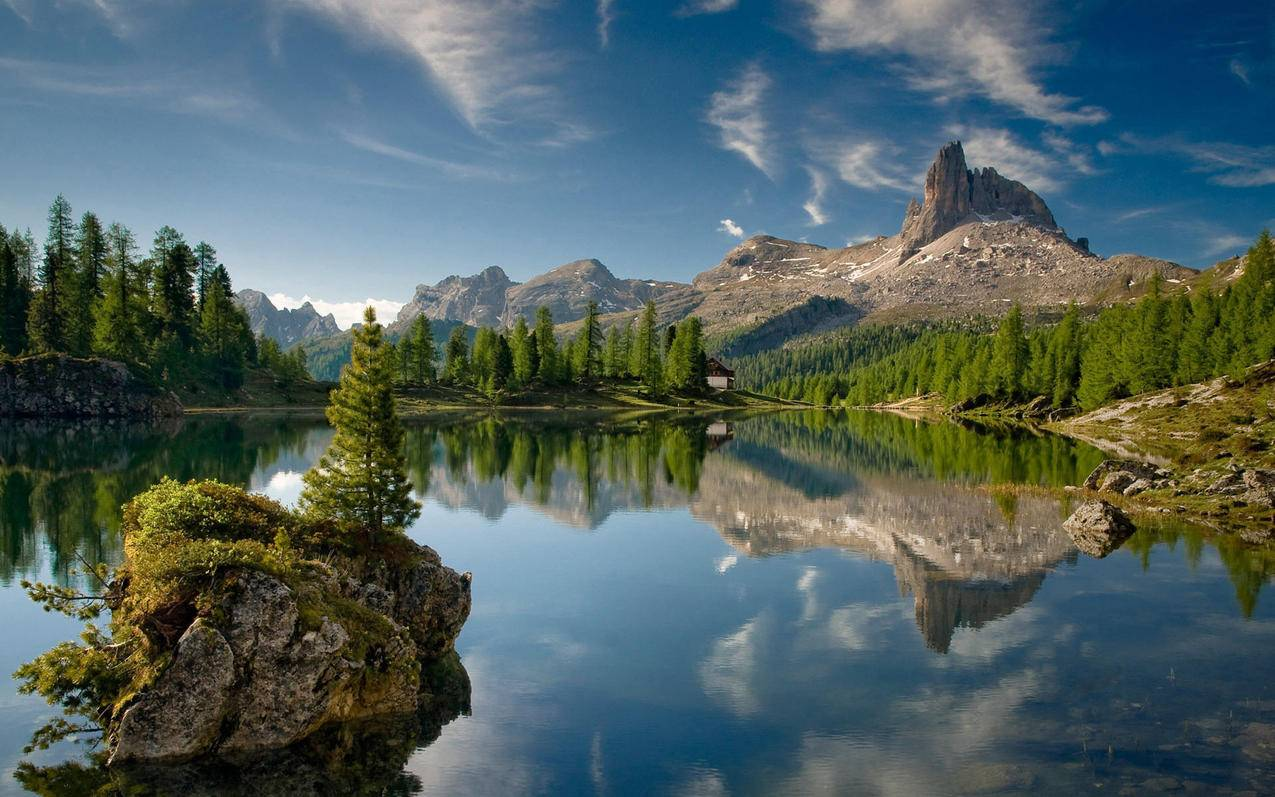

<class 'numpy.ndarray'>


In [20]:
from cv2 import waitKey
path = './img/hill.jpg'
src=cv2.imread(path)
cv2.imshow('raw image',src)
cv2.waitKey(0)
image_src = Image.fromarray(cv2.cvtColor(src,cv2.COLOR_BGR2RGB))
display(image_src)
print(type(src))


In [4]:
print(src.shape)

(797, 1275, 3)


关于灰度化，主要目的是减少

In [5]:
def grayscale_process(src,way=1):
    row,col,channel = src.shape
    #平均法：把一个像素位置的3个通道的RGB值进行平均
    img_gray = np.zeros((row,col))
    if way == 1:
        for r in range(row):
            for l in range(col):
                img_gray[r,l]=(1/3)*src[r,l,0]+(1/3)*src[r,l,1]+(1/3)*src[r,l,2]
    #最大最小平均法    
    if way == 2:
        for r in range(row):
            for l in range(col):
                img_gray[r,l]=(1/2)*max(src[r,l,0],src[r,l,1],src[r,l,2])+(1/2)*max(src[r,l,0],src[r,l,1],src[r,l,2])
    #加权法
    if way == 3:
        for r in range(row):
            for l in range(col):
                img_gray[r,l]=(0.11)*src[r,l,0]+(0.59)*src[r,l,1]+(0.3)*src[r,l,2]
    dst = img_gray.astype("uint8")
    return dst


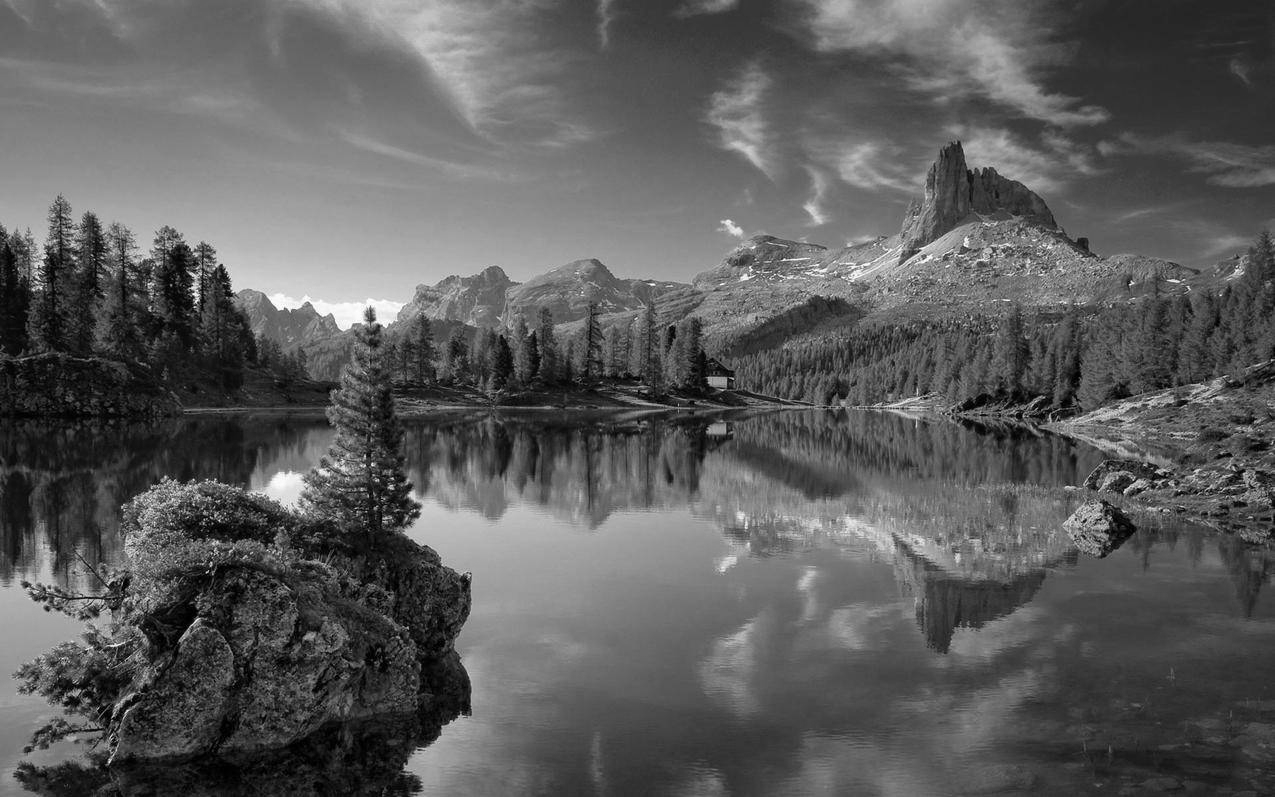

In [22]:

dst = grayscale_process(src,3)
cv2.imshow("grayscale",dst) 
cv2.waitKey(0)
image_dst = Image.fromarray(cv2.cvtColor(dst,cv2.COLOR_BGR2RGB))
display(image_dst)


In [7]:
print(dst.shape)

(797, 1275)


这里是关于高斯一阶导数滤波器的代码。一般的梯度是用$\frac{f(k)-f(k-1)}{k-(k-1)}$。另一种是先对高斯核求导，得到gd_kernel，然后用gd_kernel对图像进行卷积。

这是获取高斯核的参考
https://towardsdatascience.com/canny-edge-detection-step-by-step-in-python-computer-vision-b49c3a2d8123

这是算导数的参考
https://stackoverflow.com/questions/35012080/how-to-apply-a-partial-derivative-gaussian-kernel-to-an-image-with-opencv


这是对scipy中对高斯二阶导的讨论
https://dsp.stackexchange.com/questions/78280/are-scipy-second-order-gaussian-derivatives-correct

这个是对scipy.ndimage的一个调用
https://www.hdm-stuttgart.de/~maucher/Python/ComputerVision/html/Filtering.html#id1

这里有一些资源

https://theailearner.com/image-processing/

https://theailearner.com/ai-quiz/

https://staff.fnwi.uva.nl/r.vandenboomgaard/IPCV20172018/LectureNotes/IP/LocalStructure/index.html
之后要用scipy.ndimage.gaussian_filter进行验证

In [8]:
def gaussian_kernel(size, sigma=1):
    half_size = int(size) // 2
    x, y = np.mgrid[-half_size:half_size+1, -half_size:half_size+1]
    normal = 1 / (2.0 * np.pi * sigma**2)
    gk =  np.exp(-((x**2 + y**2) / (2.0*sigma**2))) * normal

    gaussian_first_deriv_x = np.zeros_like(gk)
    gaussian_first_deriv_y = np.zeros_like(gk)
    #assert(size % 2 == 1) # I assume you are using an odd kernel_size
    #print("size",size)
    half_kernel_size = int(size / 2)
    #print("half:",half_kernel_size)
    for i in range(size):
        #print(i)
        x = - half_size + i
        y = - half_size + i
        #print(x)
        factor_x = - x/ (sigma**2)
        #print("factor_x",factor_x)
        factor_y = - y/ (sigma**2)
        print("factor_x",x)
        print("gk[",i,"]",gk[i])
        gaussian_first_deriv_x[i] = gk[i] * factor_x
        gaussian_first_deriv_y[i] = gk[i] * factor_y
    gaussian_first_deriv_y=gaussian_first_deriv_y.T
    return gk,gaussian_first_deriv_x,gaussian_first_deriv_y
#def gd_kernel(kernel):



In [9]:
gk,gd_x,gd_y=gaussian_kernel(5)
print("----------------------")
print("-----gk---------------")
print(gk)
print("-----gd_x-------------")
print(gd_x)
print("-----gd_y-------------")
print(gd_y)

factor_x -2
gk[ 0 ] [0.00291502 0.01306423 0.02153928 0.01306423 0.00291502]
factor_x -1
gk[ 1 ] [0.01306423 0.05854983 0.09653235 0.05854983 0.01306423]
factor_x 0
gk[ 2 ] [0.02153928 0.09653235 0.15915494 0.09653235 0.02153928]
factor_x 1
gk[ 3 ] [0.01306423 0.05854983 0.09653235 0.05854983 0.01306423]
factor_x 2
gk[ 4 ] [0.00291502 0.01306423 0.02153928 0.01306423 0.00291502]
----------------------
-----gk---------------
[[0.00291502 0.01306423 0.02153928 0.01306423 0.00291502]
 [0.01306423 0.05854983 0.09653235 0.05854983 0.01306423]
 [0.02153928 0.09653235 0.15915494 0.09653235 0.02153928]
 [0.01306423 0.05854983 0.09653235 0.05854983 0.01306423]
 [0.00291502 0.01306423 0.02153928 0.01306423 0.00291502]]
-----gd_x-------------
[[ 0.00583005  0.02612847  0.04307856  0.02612847  0.00583005]
 [ 0.01306423  0.05854983  0.09653235  0.05854983  0.01306423]
 [ 0.          0.          0.          0.          0.        ]
 [-0.01306423 -0.05854983 -0.09653235 -0.05854983 -0.01306423]
 [-0.0

In [10]:
def convolve(img,fil,mode = 'same'):                #分别提取三个通道

    if mode == 'fill':
        h = fil.shape[0] // 2
        w = fil.shape[1] // 2
        img = np.pad(img, ((h, h), (w, w),(0, 0)), 'constant')
    # conv_b = _convolve(img[:,:,0],fil)              #然后去进行卷积操作
    # conv_g = _convolve(img[:,:,1],fil)
    # conv_r = _convolve(img[:,:,2],fil)
    conv = _convolve(img,fil)
 
    #dstack = np.dstack([conv_b,conv_g,conv_r])      #将卷积后的三个通道合并
    return conv                                   #返回卷积后的结果
def _convolve(img,fil):         
     
    fil_heigh = fil.shape[0]                        #获取卷积核(滤波)的高度
    fil_width = fil.shape[1]                        #获取卷积核(滤波)的宽度
   
    conv_heigh = img.shape[0] - fil.shape[0] + 1    #确定卷积结果的大小
    conv_width = img.shape[1] - fil.shape[1] + 1

    conv = np.zeros((conv_heigh,conv_width),dtype = 'uint8')
     
    for i in range(conv_heigh):
        for j in range(conv_width):                 #逐点相乘并求和得到每一个点
            conv[i][j] = wise_element_sum(img[i:i + fil_heigh,j:j + fil_width ],fil)
    return conv
     
def wise_element_sum(img,fil):
    res = (img * fil).sum() 
    if(res < 0):
        res = 0
    elif res > 255:
        res  = 255
    return res

In [11]:
img_gd_x = convolve(dst,50*gd_x,'same')
img_gd_y = convolve(dst,50*gd_y,'same')

In [12]:
G = np.hypot(img_gd_x, img_gd_y)
G = G / G.max() * 255
theta = np.arctan2(img_gd_y, img_gd_x)

[[ 48  81 121 ...   0   0   0]
 [ 92  94  92 ...   0   0   0]
 [114 106  90 ...   0   0   0]
 ...
 [  0  10  47 ...  72  58  64]
 [ 66  83 102 ... 135  86  32]
 [ 93  81  70 ... 108  37   0]]
[[ 0  0  0 ...  0  0  0]
 [ 7  0  0 ...  0  0  0]
 [ 5  0  0 ...  0  0  0]
 ...
 [ 0  0  5 ...  0 30 36]
 [ 0 18 36 ...  0  2 26]
 [ 0 23 40 ...  0  0  0]]
(793, 1271)


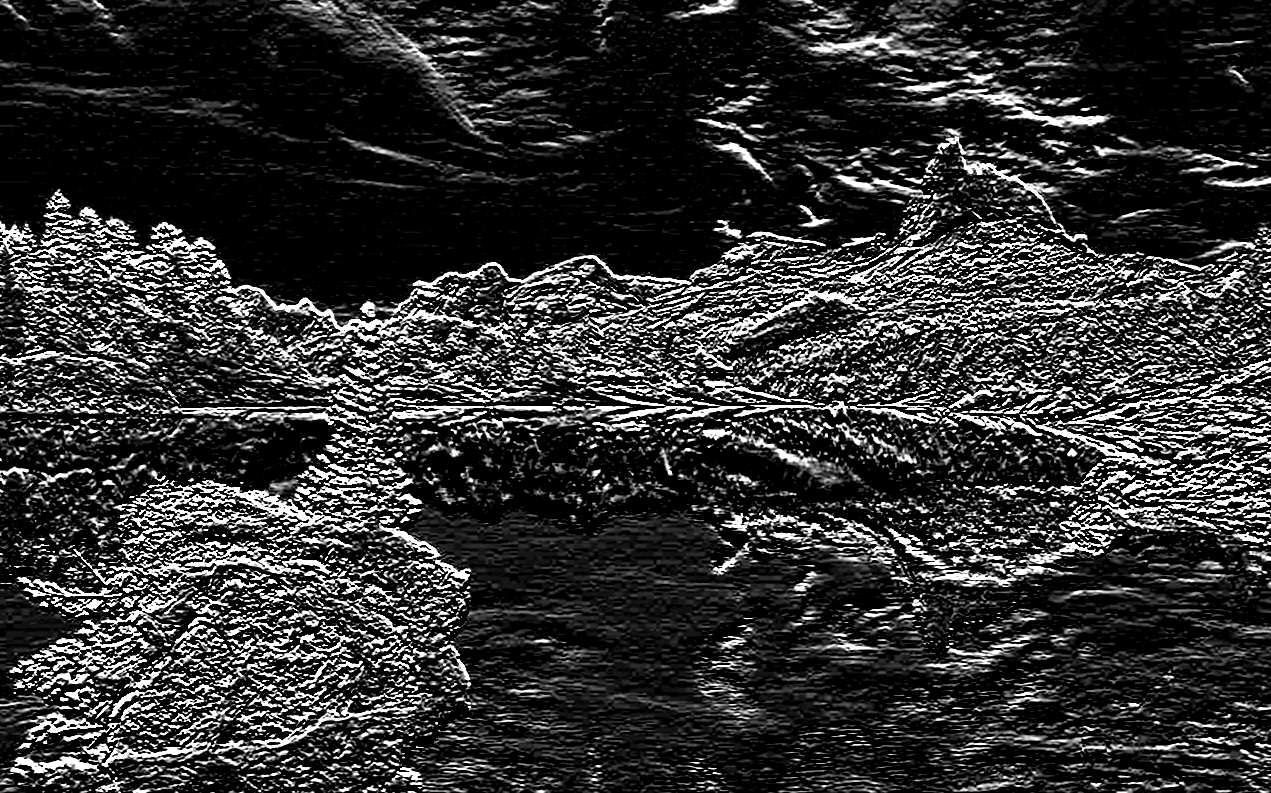

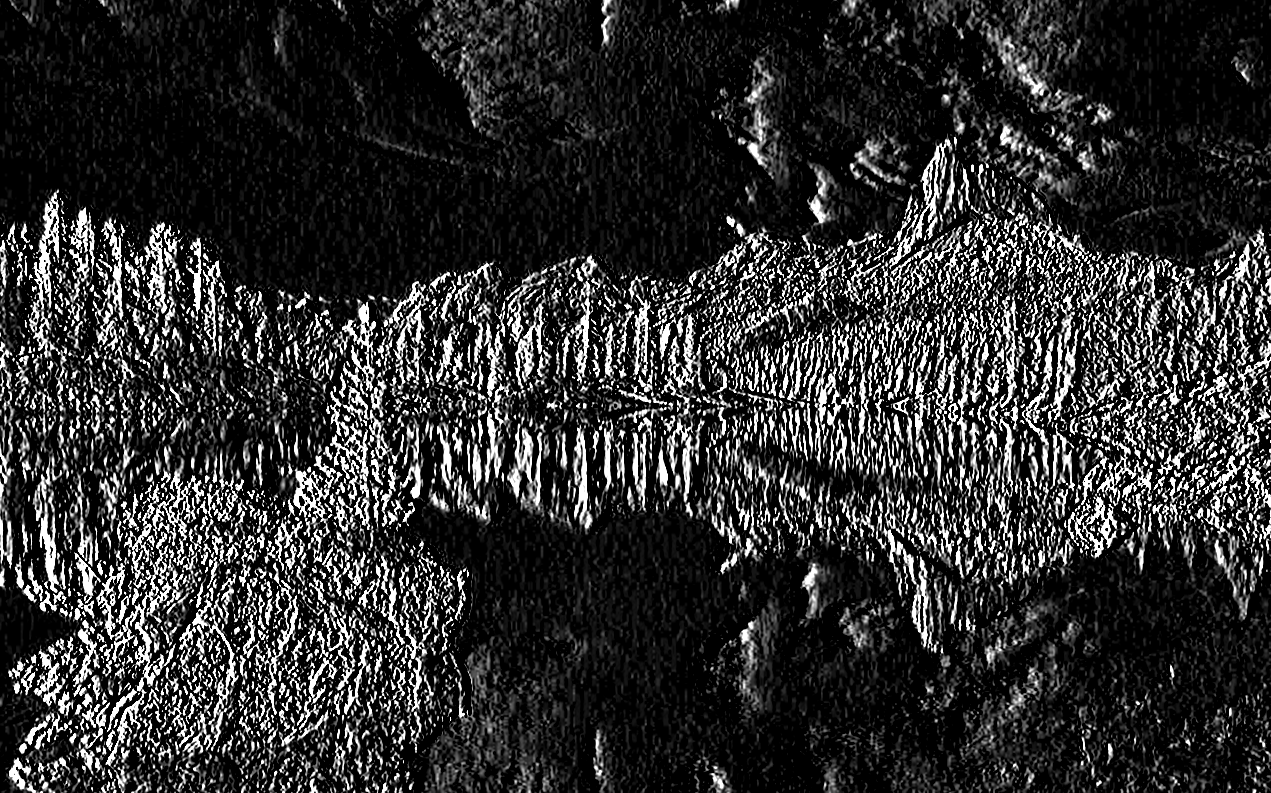

In [23]:
print(img_gd_x)
print(img_gd_y)
print(img_gd_x.shape)
cv2.imshow('img_gd_x',img_gd_x)
cv2.imshow('img_gd_y',img_gd_y)
#cv2.imshow('G',G)
cv2.waitKey(0)
image_gd_x = Image.fromarray(cv2.cvtColor(img_gd_x,cv2.COLOR_BGR2RGB))
display(image_gd_x)
image_gd_y = Image.fromarray(cv2.cvtColor(img_gd_y,cv2.COLOR_BGR2RGB))
display(image_gd_y)

<class 'numpy.ndarray'>
[[33.97  57.3   85.6   ...  0.     0.     0.   ]
 [65.25  66.5   65.06  ...  0.     0.     0.   ]
 [80.75  74.94  63.66  ...  0.     0.     0.   ]
 ...
 [ 0.     7.074 33.44  ... 50.94  46.2   51.94 ]
 [46.7   60.06  76.5   ... 95.5   60.8   29.16 ]
 [65.8   59.56  57.03  ... 76.4   26.17   0.   ]]


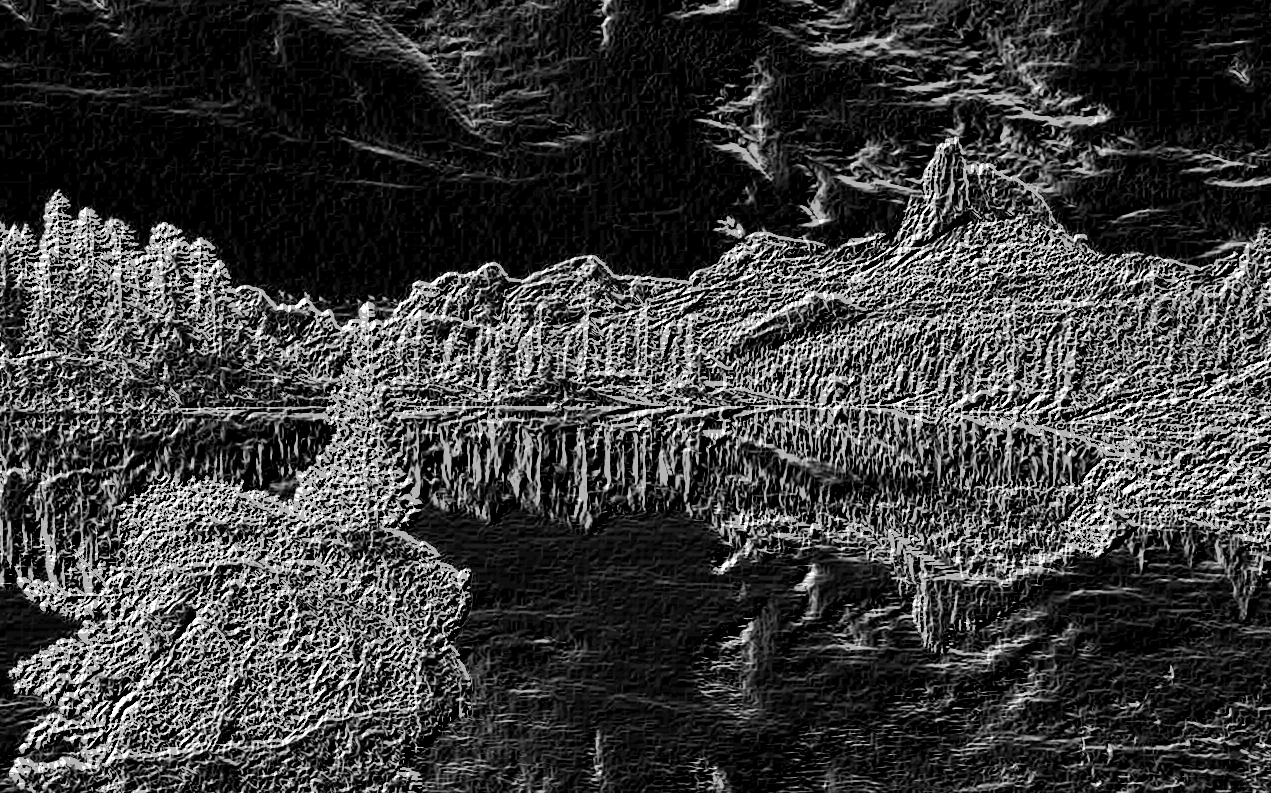

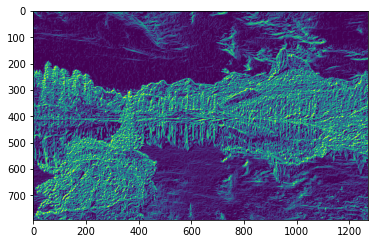

In [33]:
print(type(G))
print(G)
mixed = G.astype("uint8")
cv2.imshow("window",mixed)
cv2.waitKey(0)
image_mixed = Image.fromarray(cv2.cvtColor(mixed,cv2.COLOR_BGR2RGB))
display(image_mixed)
plt.imshow(mixed)
plt.show()

上面算出了梯度的幅值与方向。梯度图像$||\nabla f(x,y)||$ (代码中是mixed)在一些局部极大值附近会包含一些宽脊，下一步要进一步细化。NMS是一种比较常用的方法，其实质就是规定边缘法线/梯度方向的多个离散方向。比如说，有规定4个基本方向、水平、垂直、+45°和-45°，分别表示为$d_1,d_2,d_3,d_4$,NMS的主要步骤：
1. 对于当前位置的方向 $\alpha(x,y)$, 寻找最接近它的$d_k$
2. 

In [46]:
def non_max_suppression(img, arc_angle):
    m,n = img.shape
    Z = np.zeros((m,n))
    angle = arc_angle* 180. / np.pi #因为之前用arctan算出来的是弧度制，后面要分类讨论，用角度比较方便
    angle[angle < 0] += 180

    for i in range(1,m-1):
        for j in range(1,n-1):
            try:
                q = 255
                r = 255
                
               #angle 0
                if (0 <= angle[i,j] < 22.5) or (157.5 <= angle[i,j] <= 180):
                    q = img[i, j+1]
                    r = img[i, j-1]
                #angle 45
                elif (22.5 <= angle[i,j] < 67.5):
                    q = img[i+1, j-1]
                    r = img[i-1, j+1]
                #angle 90
                elif (67.5 <= angle[i,j] < 112.5):
                    q = img[i+1, j]
                    r = img[i-1, j]
                #angle 135
                elif (112.5 <= angle[i,j] < 157.5):
                    q = img[i-1, j-1]
                    r = img[i+1, j+1]

                if (img[i,j] >= q) and (img[i,j] >= r):
                    Z[i,j] = img[i,j]
                else:
                    Z[i,j] = 0

            except IndexError as e:
                pass
    Z=Z.astype("uint8")
    
    return Z

In [47]:
img_NMS = non_max_suppression(mixed,theta)

<class 'numpy.ndarray'>
(793, 1271)


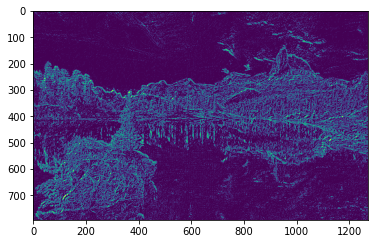

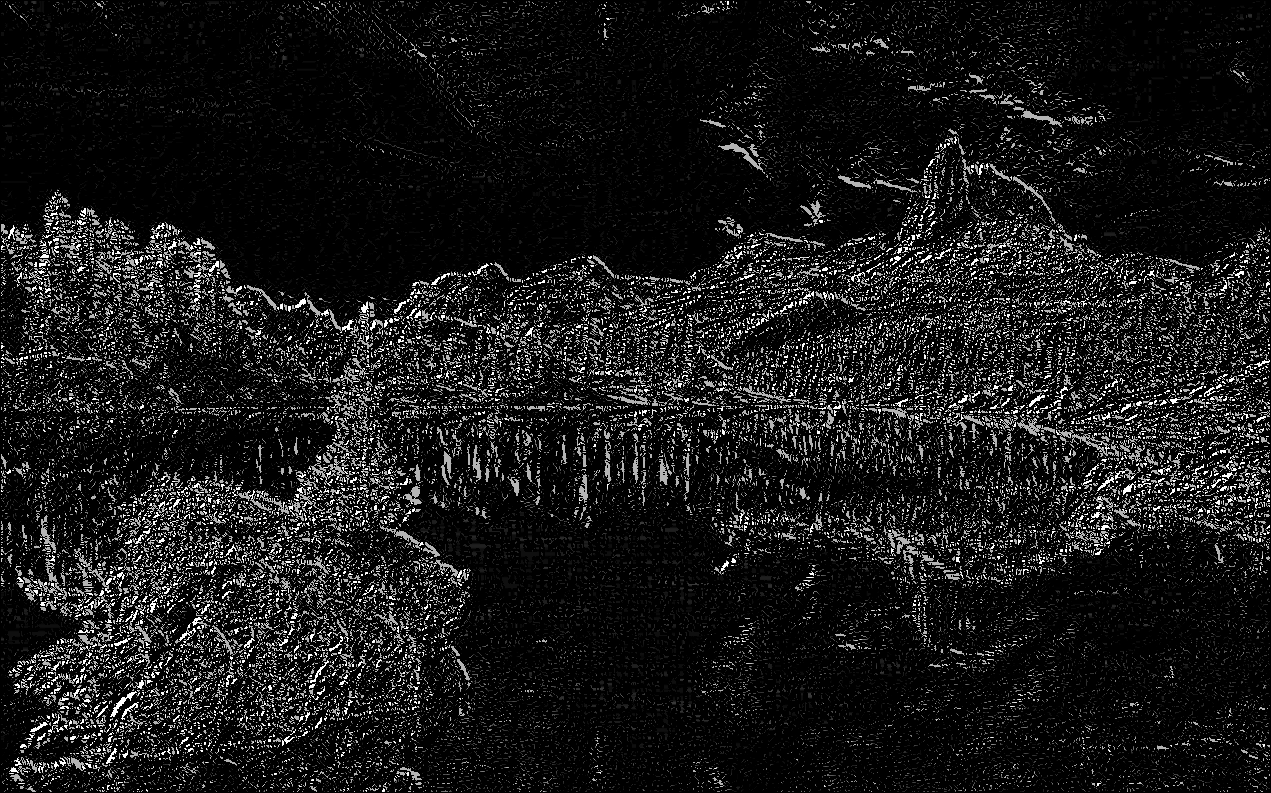

In [48]:
cv2.imshow("img_NMS",img_NMS)
cv2.waitKey(0)
print(type(img_NMS))
print(img_NMS.shape)
plt.imshow(img_NMS)
plt.show()

image_NMS = Image.fromarray(cv2.cvtColor(img_NMS,cv2.COLOR_BGR2RGB))
display(image_NMS)